# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, we will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. we will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. we will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, you should start by asking questions we might want to understand about the bike share data. Consider, for example, if we were working for Motivate. What kinds of information would we want to know about in order to make smarter business decisions? If we were a user of the bike-share service, what factors might influence how you would want to use the service?

**Question 1**: Write at least two questions related to bike sharing that you think could be answered by data.

**Answer**: * Q1 In which city this system is generating most profit?
            * Q2 How many are regularly using this system?

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

 

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
from datetime import date #operations to parse dates
import calendar #for getting weekday name from date

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar



<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above output that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

we will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    if city=='Washington':
        w=int(datum['Duration (ms)'])
        duration=w/1000/60
    else:
        n=int(datum['tripduration'])
        duration=n/60
    
    return duration

# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    if city=="NYC":
        n=datum['starttime']
        n=datetime.strptime(n,"%m/%d/%Y %H:%M:%S")
        month=n.month
        hour=n.hour
        day_of_week=calendar.day_name[n.weekday()]
    elif city=="Washington":
        w=datum['Start date']
        w=datetime.strptime(w,"%m/%d/%Y %H:%M")
        month=w.month
        hour=w.hour
        day_of_week=calendar.day_name[w.weekday()]
    else:
        c=datum['starttime']
        c=datetime.strptime(c,"%m/%d/%Y %H:%M")
        month=c.month
        hour=c.hour
        day_of_week=calendar.day_name[c.weekday()]
    
    return (month, hour, day_of_week)


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [7]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    #we need condionnal conversion only for washington because category names are different only in washington,
    #in NYC and Chicago category names are same
    if city == "Washington":
         if datum['Member Type'] == 'Registered':
                user_type = 'Subscriber'
         else :
            user_type = 'Customer'   
    else:
        user_type = datum['usertype']
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [8]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}
            
            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'], new_point['hour'], new_point['day_of_week']=time_of_trip(row, city)
            new_point['user_type']=type_of_user(row, city)
            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)

In [9]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])
    


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])




<a id='eda'></a>
## Exploratory Data Analysis

Now that we have the data collected and wrangled, we're ready to start exploring the data. In this section we will write some code to compute descriptive statistics from the data. we will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**: NYC has the highest number of trips(276798). NYC has the highest proportion of trips made by subscribers(88.835902 %). Chicago has the highest proportion of trips made by short-term customers(23.774799 %).

In [10]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        #compute proportion of trips made by subscribers
        p_subscribers = n_subscribers/n_total
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total, p_subscribers)

In [11]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##
n='./data/NYC-2016-Summary.csv'
w='./data/Washington-2016-Summary.csv'
c='./data/Chicago-2016-Summary.csv'


**Comparing ridership for 3 cities in a single table**

Using the above function to create a table which show ridership for 3 different cities.
The *number_of_trips* function returns a tuple. I will convert it into list type and then manipulate data to create the table


In [13]:
columns = ['city', 'total_trips', '%age of subscriber', '%age of customers'] # column names
cities = ['NYC', 'Washington', 'Chicago']
import pandas as pd
new_obs = pd.DataFrame(columns = columns) #creating an empty dataframe with only columns names

for i, city, filename in zip(range(3), cities, [n,w,c]): #[n,w,c] is the list of filename for each city mentioned in above cell
    #filling the rows
    new_obs.loc[i] = [city,list(number_of_trips(filename))[2], list(number_of_trips(filename))[3]*100, 100 - list(number_of_trips(filename))[3]*100]
new_obs

city total_trips  %age of subscriber  %age of customers
0         NYC      276798           88.835902          11.164098
1  Washington       66326           78.028224          21.971776
2     Chicago       72131           76.225201          23.774799



**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: Average trip length for each city is:

NYC- 15.812592998

Washington- 18.9328735591

Chicago- 16.5636293688


Proportion of rides in each city which are longer than 30 minutes:

NYC- 0.07302437156337835

Washington- 0.10838886711093688

Chicago- 0.08332062497400562

In [16]:
## Use this and additional cells to answer Question 4b.                 ##
##                                                                      ##
## HINT: The csv module reads in all of the data as strings, including  ##
## numeric values. You will need a function to convert the strings      ##
## into an appropriate numeric type before you aggregate data.          ##
## TIP: For the Bay Area example, the average trip length is 14 minutes ##
## and 3.5% of trips are longer than 30 minutes.##

#using pandas to work with dataframes
import pandas as pd

def average_trip_length(filename):
    """
    This function reads the trip data of a city and return the average trip length for that city
    """
    #creating dataframe from csv file
    trip_data = pd.read_csv(filename)
    
    #calculate average length of trip for each city 
    average_trip_length = trip_data['duration'].mean()

    return (average_trip_length)

In [17]:
#Checking the function
print('NYC-', average_trip_length(n))
print('Washington-', average_trip_length(w))
print('Chicago-', average_trip_length(c))

NYC- 15.812592998
Washington- 18.9328735591
Chicago- 16.5636293688


In [18]:
def more_than_30(filename):
    """
    This function reads the trip data of a city and return the proportion of rides made in that city which are longer 
    than 30 minutes
    """
    #setting the counter variable 
    more_than_30 = 0
    
    #creating dataframe from csv file
    trip_data = pd.read_csv(filename)
    
    for duration in trip_data['duration']:
        if duration > 30:
            more_than_30 += 1
            
    #calculating proportion
    p_more_than_30 = 100*more_than_30/len(trip_data['duration'])
    
    return (p_more_than_30)

In [19]:
#Checking the function
print('NYC-', more_than_30(n), '%')
print('Washington-', more_than_30(w), '%')
print('Chicago-', more_than_30(c), '%')

NYC- 7.3024371563378345 %
Washington- 10.83888671109369 %
Chicago- 8.332062497400562 %


**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: Customers. I did this for Washington but this is same for all cities.

In [20]:
## Use this and additional cells to answer Question 4c. If you have    ##
## not done so yet, consider revising some of your previous code to    ##
## make use of functions for reusability.                              ##
##                                                                     ##
## TIP: For the Bay Area example data, you should find the average     ##
## Subscriber trip duration to be 9.5 minutes and the average Customer ##
## trip duration to be 54.6 minutes. Do the other cities have this     ##
## level of difference?                                                ##

def ridership(filename):
    """
    This function reads trip data of a city and returns average of trip duration for each type of user.
    """
    #creating dataframe from csv file
    trip_data = pd.read_csv(filename)
    
    #setting the counter variables
    customer_duration = 0
    customer_count = 0
    subscriber_duration = 0
    subscriber_count = 0

    for duration,user_type in zip(trip_data['duration'], trip_data['user_type']):
        if user_type == 'Subscriber':
            subscriber_duration += duration
            subscriber_count += 1
        else:
            customer_duration += duration
            customer_count += 1
    customer_avg = customer_duration/customer_count
    subscriber_avg = subscriber_duration/subscriber_count
        
    return ("Customer Average-", customer_avg, "Subscriber Average-", subscriber_avg)

In [21]:
print('NYC-', ridership(n))
print('Washington-', ridership(w))
print('Chicago-', ridership(c))

NYC- ('Customer Average-', 32.775951394731869, 'Subscriber Average-', 13.680790523907177)
Washington- ('Customer Average-', 41.678031392529761, 'Subscriber Average-', 12.528120499294745)
Chicago- ('Customer Average-', 30.979781133982506, 'Subscriber Average-', 12.067201690250076)


<a id='visualizations'></a>
### Visualizations

The last set of values that we computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, we will usea new library will be  here, `matplotlib`. 

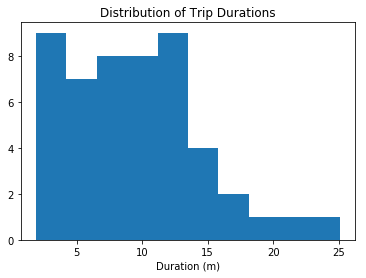

In [22]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

we will now use these functions to create a histogram of the trip times for the city you selected in question 4c.

In [23]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##

#import washington's trip info as dataframe
trip_data=pd.read_csv(w)

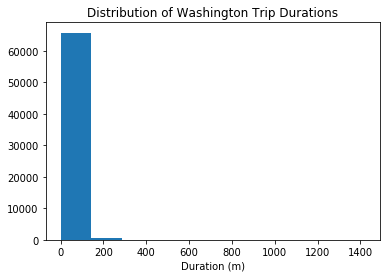

In [24]:
#creating a histogram for all trip durations
plt.hist(trip_data['duration'])
plt.title('Distribution of Washington Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In [25]:
## Use this and additional cells to answer Question 5. ##
import seaborn as sns
import numpy as np

#g = sns.FacetGrid(trip_data, col="user_type")
#g=g.map(plt.hist, 'duration')
customers = []
subscribers = []
for duration, user in zip(trip_data['duration'], trip_data['user_type']):
    if user == 'Customer':
        customers.append(duration)
    else:
        subscribers.append(duration)

In [26]:
plt.hist(subscribers, bins = np.arange(min(subscribers), max(subscribers) + 5, 5));
plt.xlim([0,75])
plt.title('Distribution of Washington Customer Trip Durations')
plt.xlabel('duration(m)');

In [27]:
plt.hist(customers, bins = np.arange(min(customers), max(customers) + 5, 5));
plt.xlim([0,75])
plt.title('Distribution of Washington Customer Trip Durations')
plt.xlabel('duration(m)')

Text(0.5,0,'duration(m)')

<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. Here are a few suggestions for questions to explore:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

If any of the questions you posed in your answer to question 1 align with the bullet points above, this is a good opportunity to investigate one of them. As part of your investigation, you will need to create a visualization. If you want to create something other than a histogram, then you might want to consult the [Pyplot documentation](https://matplotlib.org/devdocs/api/pyplot_summary.html). In particular, if you are plotting values across a categorical variable (e.g. city, user type), a bar chart will be useful. The [documentation page for `.bar()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar) includes links at the bottom of the page with examples for you to build off of for your own use.

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**: I am continuing my own observtion for Washington city.Yes pattern of ridership is different on the weekends versus weekdays.Subscribers are most likely to use the system on Saturday. Same trend for Customers. Average duration of time change depending on the day of week.

Average duration for Subscribers:
[Monday:12.306999, Tuesday:12.392428, Wednesday:12.564929, Thursday:12.523436, Friday:12.171476, Saturday:13.094494, Sunday:12.951062]

Average duration for Customers:
[Monday:40752832, Tuesday:41.777629, Wednesday:36.370252, Thursday:39.685053, Friday:40.715875, Saturday:44.589926, Sunday:43.429348]

In [28]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##

#Creating two dataframes, each for subscriber and customers for comparing trends over weekdays
#trip_data_1 = trip_data[['user_type', 'duration', 'day_of_week']]
trip_data
columns = ['month', 'hour']
trip_data.drop(columns, axis = 1, inplace = True)

In [29]:
#trip_data
my_sub = trip_data[trip_data['user_type'] == 'Subscriber']
my_cus = trip_data[trip_data['user_type'] == 'Customer']

In [30]:
my_sub = my_sub.groupby('day_of_week')['duration'].mean()
my_cus = my_cus.groupby('day_of_week')['duration'].mean()

In [31]:
sub_trend = my_sub.plot(kind = 'bar');
plt.title('distribution of subscriber trips')

Text(0.5,1,'distribution of subscriber trips')

In [32]:
cus_trend = my_cus.plot(kind='bar');
plt.title('Distribution of Customer Trip ')

Text(0.5,1,'Distribution of Customer Trip ')

<a id='conclusions'></a>
## Conclusions

 Normally, at this point in the data analysis process, we might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

**Question 7**: Putting the bike share data aside, think of a topic or field of interest where you would like to be able to apply the techniques of data science. What would you like to be able to learn from your chosen subject?

**Answer**:  I will be interested to run a similar data analysis for ambulance service using healthcare claims data. I can check which 4 major city in Texas has the highest ambulance run, and what's max proportion for the ambulance service(option1:Basic life support or advanced life support or Option2: dialaysis service or hospital run)? I can create a histogram for service distribution among these 4 major cities to see how service are distributed among different city.
 